In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tqdm import tqdm
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
import requests

In [3]:
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-Coursera/laptop_pricing_dataset_mod2.csv'
response = requests.get(url)

if response.status_code == 200:
    filename = "laptops.csv"
    with open(filename, "wb") as f:
        f.write(response.content)
    print(f"File downloaded successfully as '{filename}'")
else:
    print(f"Error downloading the file. Status code:{response.status_code}")

File downloaded successfully as 'laptops.csv'


In [4]:
df = pd.read_csv(filename, header = 0)

In [8]:
df = df._get_numeric_data()

In [6]:
#filepath = 'url'
#df = pd.read_csv(filepath, header=None)

In [7]:
#Drop the two unnecessary columns 'Unnamed:0' and 'Unnamed:0.1':
df.drop(['Unnamed: 0.1','Unnamed: 0'], axis=1, inplace=True)

In [10]:
df.head()

,Category,GPU,OS,CPU_core,Screen_Size_inch,CPU_frequency,RAM_GB,Storage_GB_SSD,Weight_pounds,Price,Screen-Full_HD,Screen-IPS_panel
0,4,2,1,5,14.0,0.551724,8,256,3.52800,978,0,1
1,3,1,1,3,15.6,0.689655,4,256,4.85100,634,1,0
2,3,1,1,7,15.6,0.931034,8,256,4.85100,946,1,0
3,4,2,1,5,13.3,0.551724,8,128,2.69010,1244,0,1
4,4,2,1,7,15.6,0.620690,8,256,4.21155,837,1,0


### 1. Using Cross Validation to improve the model

In [11]:
#Use Cross validation to improve the model
#Divide the dataset into x_data and y_data parameters:
y_data = df['Price']
x_data = df.drop('Price', axis=1)

In [12]:
#Split the data into training and testing subsets
#Reserve 10% of the data set for testing purposes:
x_train,x_test,y_train,y_test = train_test_split(x_data,y_data,test_size=0.10,random_state=1)

print("Number of test samples:", x_test.shape[0])
print("Number of training samples:", x_train.shape[0])

Number of test samples: 24
Number of training samples: 214


In [13]:
#Create a single variable linear regression model using "CPU_frequency"
#Print the R^2 of this model for the training and testing subsets:
lre = LinearRegression()
lre.fit(x_train[['CPU_frequency']],y_train)
r2_test = lre.score(x_test[['CPU_frequency']], y_test)
r2_train = lre.score(x_train[['CPU_frequency']], y_train)

print("The R^2 for the training subsets is", r2_train)
print("The R^2 for the testing subsets is", r2_test)

The R^2 for the training subsets is 0.14829792099817973
The R^2 for the testing subsets is -0.06599437350393789


In [14]:
#Run a 4-fold cross validation on the model
#Print the mean value of R^2 score and its standard deviation:
Rcross = cross_val_score(lre, x_data[['CPU_frequency']], y_data, cv=4)

print("The mean value of R^2 score is", Rcross.mean())
print("The standard deviatino is", Rcross.std())

The mean value of R^2 score is -0.16109232388595113
The standard deviatino is 0.384957978666471


### 2. Overfitting

In [16]:
#Split the data set into training and testing components again
#This time reserve 50% of the data set for testing:
x_train,x_test,y_train,y_test = train_test_split(x_data, y_data, test_size=0.50, random_state=0)

#Fixing random_state to a fixed quantity helps maintain uniformity between multiple

print("Number of test samples:", x_test.shape[0])
print("Number of training samples:", x_train.shape[0])

Number of test samples: 119
Number of training samples: 119


In [17]:
#Create polynomial features using the single attribute
#Evaluate the R^2 scores of the model created using different degress of polynomial features
#Range: 1-5
#Save this set of values of R^2 score as a list:
lre = LinearRegression()
Rsqu_test = []

order = [1,2,3,4,5]
for n in order:
    pr = PolynomialFeatures(degree=n)
    x_train_pr = pr.fit_transform(x_train[['CPU_frequency']])
    x_test_pr = pr.fit_transform(x_test[['CPU_frequency']])
    lre.fit(x_train_pr, y_train)
    
    Rsqu_test.append(lre.score(x_test_pr, y_test))

Text(0.5, 1.0, 'R^2 using test data')

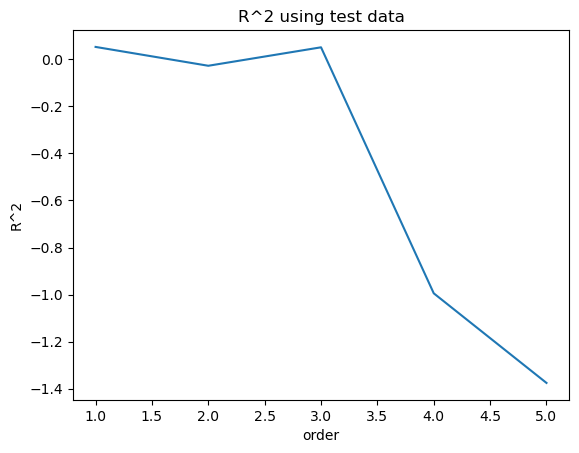

In [18]:
#Plot the values of R^2 scores against the order
#Note the point where the score drops:
plt.plot(order, Rsqu_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 using test data')

### 3. Ridge Regression

In [20]:
#Use multiple features: CPU_frequency, RAM_GB, Storage_GB_SSD, CPU_core, OS, GPU, Category
#Create a polynomial feature model using all parameters with degree=2
#Create the training and testing attribute sets:
pr1 = PolynomialFeatures(degree=2)
x_train_pr1=pr1.fit_transform(x_train[['CPU_frequency', 'RAM_GB', 'Storage_GB_SSD','CPU_core','OS','GPU','Category']])
x_test_pr1=pr1.fit_transform(x_test[['CPU_frequency', 'RAM_GB', 'Storage_GB_SSD','CPU_core','OS','GPU','Category']])

In [22]:
#Create a Ridge Regression model and evaluate it using alpha [0.001-1]
#Create a list of all Ridge Regression R^2 scores for training and testing data:
Rsqu_train = []
Rsqu_test = []
Alpha = np.arange(0.001,1,0.001)
pbar=tqdm(Alpha)

for alpha in pbar:
    RigeModel = Ridge(alpha=alpha)
    RigeModel.fit(x_train_pr1, y_train)
    test_score = RigeModel.score(x_test_pr1, y_test)
    train_score = RigeModel.score(x_train_pr1, y_train)
    pbar.set_postfix({"Test Score": test_score, "Train Score": train_score})
    
    Rsqu_test.append(test_score)
    Rsqu_train.append(train_score)

100%|██████████| 999/999 [00:02<00:00, 337.80it/s, Test Score=0.423, Train Score=0.669]


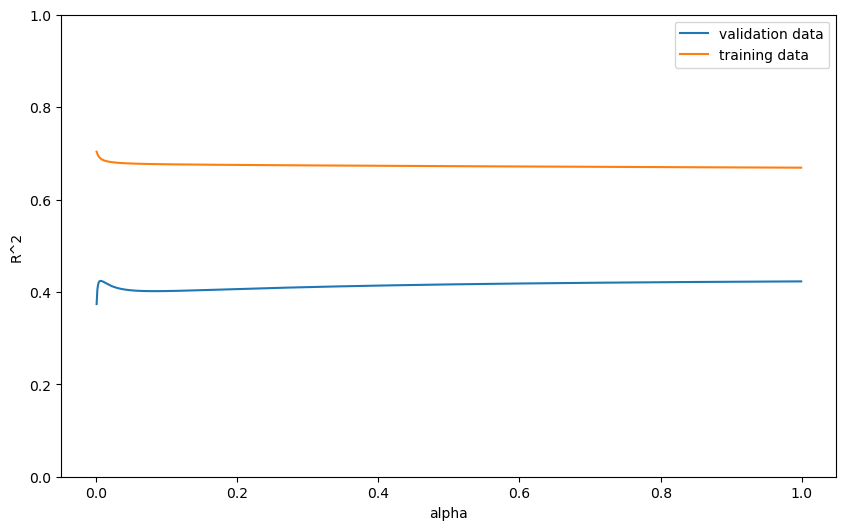

In [28]:
#Plot the R^2 values for training and testing sets with respect to the value of alpha:
width = 10
height = 6
plt.figure(figsize=(width,height))

plt.plot(Alpha, Rsqu_test, label='validation data')
plt.plot(Alpha, Rsqu_train, label='training data')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.ylim(0,1)
plt.legend()

### 4. Grid Search

In [30]:
#Use GridSearchCV to identify the value of alpha for which the model performs best
#Assume the set of alpha values to be used as
#{0.0001,0.001,0.01,0.1,1,10}

#Create a dictionary of parameter values:
parameters1 = [{'alpha': [0.0001,0.001,0.01,0.1,1,10]}]

In [31]:
#Create a Ridge instance and run Grid Search using a 4 fold cross validation
RR = Ridge()
Grid1 = GridSearchCV(RR, parameters1, cv=4)

In [32]:
#Fit the Grid Search to the training data:
Grid1.fit(x_train[['CPU_frequency','RAM_GB','Storage_GB_SSD','CPU_core','OS','GPU','Category']], y_train)

GridSearchCV(cv=4, estimator=Ridge(),
             param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}])

In [33]:
#Print the R^2 score for the test data using the estimator that uses the derived optimum value of alpha:
BestRR = Grid1.best_estimator_
BestRR.score(x_test[['CPU_frequency','RAM_GB','Storage_GB_SSD','CPU_core','OS','GPU','Category']], y_test)

0.300990504869182